In [1]:
import pygad
import numpy as np
from model.build_rocket import RocketModel
import math
import sys
import os
import sys, os
import warnings
import contextlib
import io
import re

import builtins


In [2]:

params_list = [11.5 * 1e6, 2.9, 0.23125, 190, 
                11.5 * 1e6, 2.9, 0.23125, 190,
                2,
                2.6]
bounds = [[1e6, 30e6], [1, 9], [0.05, 0.6], [2, 200],
          [1e6, 30e6], [1, 9], [0.05, 0.6], [2, 200],
          [1, 10],
          [1, 10]
 ]

bounds_norm = [[0, 1], [0, 1], [0, 1], [0, 1],
          [0, 1], [0, 1], [0, 1], [0, 1],
          [0, 1],
          [0, 1]
 ]

def normalize(parameters_list, bounds):
    normalized_list = []
    for param, bound in zip(params_list, bounds):
        lower_bound = bound[0]
        upper_bound = bound[1]
        norm_param = (param - lower_bound) / (upper_bound - lower_bound)
        normalized_list.append(norm_param)
    return normalized_list

def denormalize(norm_params_list, bounds):
    denormalized_list = []
    for norm_param, bound in zip(norm_params_list, bounds):
        lower_bound = bound[0]
        upper_bound = bound[1]
        denorm_param = (norm_param * (upper_bound - lower_bound)) + lower_bound
        denormalized_list.append(denorm_param)
    return denormalized_list

def fitness_func(parameters_list, solution_idx):
    parameters_list = denormalize(parameters_list, bounds)
    engineParams = {"oxName": "LOX",
                    "fuelName": "RP-1",
                    "combPressure": parameters_list[0],
                    "MR": parameters_list[1],
                    "nozzleDiam": parameters_list[2],
                    "eps": parameters_list[3]}

    engineParamsFirst = {"oxName": "LOX",
                    "fuelName": "RP-1",
                    "combPressure": parameters_list[4],
                    "MR": parameters_list[5],
                    "nozzleDiam": parameters_list[6],
                    "eps": parameters_list[7]}

    upperStageStructureParams = {"oxName": "LOX",
                                 "fuelName": "RP1",
                                 "MR": parameters_list[1],
                                 "tankPressure": 0.1,
                                 "radius": parameters_list[8],
                                } # 0 porque ainda nao temos esse valor
    firstStageStructureParams = {"oxName": "LOX",
                                "fuelName": "RP1",
                                "MR": parameters_list[5],
                                "tankPressure": 0.1,
                                "radius": parameters_list[9],
                            } # 0 porque ainda nao temos esse valor
    payloadBayParams = {"payloadHeight": 6.7,
                    "payloadRadius": 4.6/2,
                    "payloadMass": 7500,
                    "lowerStageRadius": parameters_list[8],
                    "lowerRocketSurfaceArea": 0} # 0 porque ainda nao temos esse valor

    rocket_model = RocketModel(upperEngineParams=engineParams,
                               firstEngineParams=engineParamsFirst,
                               payloadBayParams=payloadBayParams,
                               upperStageStructureParams=upperStageStructureParams,
                               firstStageStructureParams = firstStageStructureParams,
                               deltaV_upperStage=8500,
                               deltaV_landing=2000,
                               deltaV_firstStage=3500,
                               nEnginesUpperStage=1,
                               nEnignesFirstStage=10)

    try:
        rocket_model.build_all()
        glow = rocket_model.glow

    except:
        return 0
    #enablePrint()

    #print(rocket_model.upperStageEngine.thrustVac)
    #print(rocket_model.m_0_2)

    if math.isnan(glow):
        return 0
    if math.isnan(rocket_model.m_0_1):
        return 0
    if math.isnan(rocket_model.m_0_2):
        return 0
    if rocket_model.m_0_1 <= 0:
        return 0
    if rocket_model.m_0_2 <= 0:
        return 0
    if rocket_model.m_p_1 <= 0:
        return 0
    if rocket_model.m_p_2 <= 0:
        return 0
    if rocket_model.upperStageStructure.oxTankCylHeight < 0:
        return 0
    if rocket_model.upperStageStructure.fuelTankCylHeight < 0:
        return 0
    if rocket_model.firstStageStructure.oxTankCylHeight < 0:
        return 0
    if rocket_model.firstStageStructure.fuelTankCylHeight  < 0:
        return 0
    if rocket_model.upperStageEngine.thrustVac * 1<= 0.8 * rocket_model.m_0_2 * 9.81:
        return 0
    if rocket_model.firstStageEngine.thrustSea * 10 <= 1.3 * rocket_model.glow * 9.81: # Multiplicar pelo número de motores (9)
        return 0

    #print(rocket_model.glow * 9.81 * 1.3)
    #print(rocket_model.firstStageEngine.thrustSea * 10)

    #print(0.8 * rocket_model.m_0_2 * 9.81)
    #print(rocket_model.upperStageEngine.thrustVac * 1)

    #glow = glow / 100000
    fitness = (1.0/glow) * 100000
    return fitness

norm = normalize(params_list, bounds)
fitness_func(norm, 0)
norm = normalize(params_list, bounds)
denorm = denormalize(norm, bounds)


In [3]:
num_generations = 50
num_parents_mating = 50

fitness_function = fitness_func

sol_per_pop = 500
num_genes = len(params_list)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

mutation_probability = 0.2

crossover_type = "scattered"

mutation_type = "random"
last_fitness = 0
def on_generation(ga_instance):
    global last_fitness
    gen_string = "Generation = {generation}".format(generation=ga_instance.generations_completed)
    fitness_string = "Fitness = {fitness:.4f}".format(fitness=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1])
    change_string = "Change = {change:.4f}".format(change=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness)
    print( gen_string, fitness_string, change_string)
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]



In [4]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability,
                       gene_space={'low': 0, 'high': 1},
                       init_range_high=init_range_high,
                       init_range_low=init_range_low,
                       parallel_processing=["thread", 8],
                       on_generation=on_generation,
                       gene_type=float)


In [5]:
ga_instance.run()


/Users/pdcos/Documents/Estudos/Mestrado/Tese/Implementação da Tese do Jentzsch/rocket_optimization_implementation/model/structure/stage_structure.py:227: RuntimeWarning: invalid value encountered in double_scalars
  mass = 4.95 * (area ** 1.15)


Generation = 1 Fitness = 0.1579 Change = 0.1579
Generation = 2 Fitness = 0.1689 Change = 0.0110


/opt/homebrew/anaconda3/envs/deeplearning/lib/python3.9/site-packages/proptools/nozzle.py:102: RuntimeWarning: divide by zero encountered in double_scalars
  * (p_e / p_c)**(1 / gamma) \
/opt/homebrew/anaconda3/envs/deeplearning/lib/python3.9/site-packages/proptools/nozzle.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  * ((gamma + 1) / (gamma - 1)*( 1 - (p_e / p_c)**((gamma -1) / gamma)))**0.5
/opt/homebrew/anaconda3/envs/deeplearning/lib/python3.9/site-packages/proptools/nozzle.py:101: RuntimeWarning: invalid value encountered in multiply
  AtAe = ((gamma + 1) / 2)**(1 / (gamma - 1)) \
/opt/homebrew/anaconda3/envs/deeplearning/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/homebrew/anaconda3/envs/deeplearning/lib/python3.9/site-packages/proptools/nozzle.py:53: RuntimeWarning: divide 

Generation = 3 Fitness = 0.1923 Change = 0.0234


KeyboardInterrupt: 

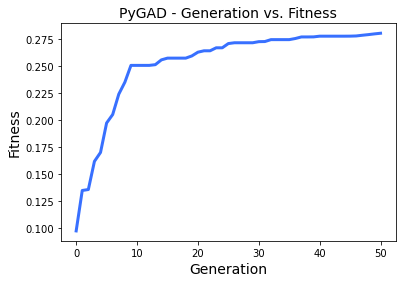

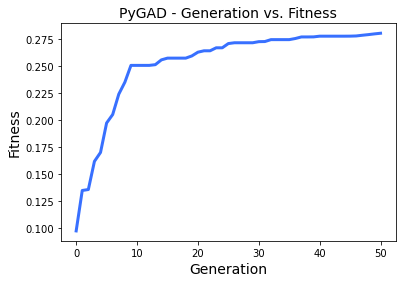

In [ ]:
ga_instance.plot_fitness()


In [ ]:
best_solution = ga_instance.best_solution()[0]
denormalize(best_solution, bounds)

[2812818.256387844,
 3.362071998982251,
 0.3940522801128269,
 194.80149420534428,
 25754016.865657672,
 3.420235396557527,
 0.10121062177218446,
 30.398990856569228,
 1.8477644693415212,
 2.520991984393139]

In [ ]:
fitness_func(ga_instance.best_solution()[0], 0)

0.2806127793477944

In [ ]:
def rocket_func(parameters_list):
    parameters_list = denormalize(parameters_list, bounds)
    engineParams = {"oxName": "LOX",
                    "fuelName": "RP-1",
                    "combPressure": parameters_list[0],
                    "MR": parameters_list[1],
                    "nozzleDiam": parameters_list[2],
                    "eps": parameters_list[3]}

    engineParamsFirst = {"oxName": "LOX",
                    "fuelName": "RP-1",
                    "combPressure": parameters_list[4],
                    "MR": parameters_list[5],
                    "nozzleDiam": parameters_list[6],
                    "eps": parameters_list[7]}

    upperStageStructureParams = {"oxName": "LOX",
                                 "fuelName": "RP1",
                                 "MR": parameters_list[1],
                                 "tankPressure": 0.1,
                                 "radius": parameters_list[8],
                                } # 0 porque ainda nao temos esse valor
    firstStageStructureParams = {"oxName": "LOX",
                                "fuelName": "RP1",
                                "MR": parameters_list[5],
                                "tankPressure": 0.1,
                                "radius": parameters_list[9],
                            } # 0 porque ainda nao temos esse valor
    payloadBayParams = {"payloadHeight": 6.7,
                    "payloadRadius": 4.6/2,
                    "payloadMass": 7500,
                    "lowerStageRadius": parameters_list[8],
                    "lowerRocketSurfaceArea": 0} # 0 porque ainda nao temos esse valor

    rocket_model = RocketModel(upperEngineParams=engineParams,
                               firstEngineParams=engineParamsFirst,
                               payloadBayParams=payloadBayParams,
                               upperStageStructureParams=upperStageStructureParams,
                               firstStageStructureParams = firstStageStructureParams,
                               deltaV_upperStage=8500,
                               deltaV_landing=2000,
                               deltaV_firstStage=3500,
                               nEnginesUpperStage=1,
                               nEnignesFirstStage=10)
    try:
        rocket_model.build_all()
        glow = rocket_model.glow
    except:
        glow = 1e19
    if math.isnan(glow):
        glow = 1e19
    if math.isnan(rocket_model.m_0_1):
        glow = 1e19
    if math.isnan(rocket_model.m_0_2):
        glow = 1e19
    if rocket_model.m_0_1 <= 0:
        glow = 1e19
    if rocket_model.m_0_2 <= 0:
        glow = 1e19
    if rocket_model.m_p_1 <= 0:
        glow = 1e19
    if rocket_model.m_p_2 <= 0:
        glow = 1e19
    if rocket_model.upperStageStructure.oxTankCylHeight <=0:
        glow = 1e19
    if rocket_model.upperStageStructure.fuelTankCylHeight <= 0:
        glow = 1e19
    if rocket_model.firstStageStructure.oxTankCylHeight <=0:
        glow = 1e19
    if rocket_model.firstStageStructure.fuelTankCylHeight <=0:
        glow = 1e19
    if rocket_model.upperStageEngine.thrustVac * 1<= 0.8 * rocket_model.m_0_2 * 9.81:
        glow = 1e19
    if rocket_model.firstStageEngine.thrustSea * 10 <= 1.3 * rocket_model.glow * 9.81: # Multiplicar pelo número de motores (9)
        glow = 1e19

    #print(rocket_model.upperStageEngine.thrustVac)
    #print(rocket_model.m_0_2)

    if math.isnan(glow):
        glow = 1e19
    #glow = glow / 100000
    fitness = 1.0/glow * 100000
    print(fitness)
    return rocket_model

rocket_model = rocket_func(ga_instance.best_solution()[0])

0.2806127793477944


In [ ]:
rocket_model.print_all_parameters()

***** Payload Bay *****
Cone Area: 37.653733282525664 [kg]
Cylinder Area: 96.82388558363742 [kg]
Frustrum Area: 39.24711702202246 [kg]
Total Payload Fairing Mass: 1609.760647978943 [kg]
Electronic Mass: 414.5588058903621 [kg]
Power Mass: 96.37248560533249 [kg]
Total Payload Mass: 9620.691939474636 [kg]
***** Upper Stage Engine *****
Isp Vac (s): 395.54229922357007
Isp Sea (s): (236.1022545597154, 'Separated (Psep=4.96091e+06, epsSep=16.5582)')
Mass flow (kg/s): 187.4125992873206
Thrust Vac (kN): 881.4312006937672
Thrust Sea (kN): -1494.259265119839
***** Upper Stage Structure *****
Ox Tank Cylyndrical Height: 3.868886287264167 [m]
Fuel Tank Cylyndrical Height: 0.15488376661794642 [m]
Ox Tank Volume: 67.92399940925776 [m3]
Fuel Tank Volume: 28.087121880964514 [m3]
Intertank Structure Mass: 828.2629688196562 [kg]
Separation Explosives Mass: 8.370001987342933 [kg]
Tank Fairing Mass: 612.9873158724041 [kg]
Total Stage Height: 15.575528913046998 [m]
Total Stage Dry Mass: 2885.2228843027433 

In [ ]:
rocket_model.firstStageStructure.fuelTankCylHeight

0.08471155633480004

In [ ]:
rocket_model.glow

356362.95764013997

In [ ]:
1/1e19

1e-19

In [ ]:
denormalize(ga_instance.best_solution()[0], bounds)

[2812818.256387844,
 3.362071998982251,
 0.3940522801128269,
 194.80149420534428,
 25754016.865657672,
 3.420235396557527,
 0.10121062177218446,
 30.398990856569228,
 1.8477644693415212,
 2.520991984393139]